# Программа визуализации расчетов Уравнения Переноса

### Считывание рассчитанных значений из файла

In [1]:
def read1DArea(filename):
    file = open(filename, "r")
    
    points = []
    frames = []

    file.readline()
    
    for line in file:
        if "error=" in line:
            break
        elif "t=" in line:
            frames.append(points.copy())
            points.clear()
        else:
            point = [float(val) for val in line.split("\t") if val != ""][:2]
            points.append( [point[0], point[1]])
    file.close()
    return frames

In [2]:
cat = "CalculationResults"
subcats = ["Godunov", "MUSCL", "THINC_Godunov", "THINC_MUSCL"]

In [3]:
import os
import re

solutions = {}
solutions["exact"] = {}

for subcat in subcats:
    directory = cat+"/"+subcat
    solutions[subcat] = {}
    for entry in os.listdir(directory):
        frames = read1DArea(directory+"/"+entry)
        
        parsedEntry = re.findall(r'\d+', entry)
        N = int(parsedEntry[0])
        T = int(parsedEntry[1])
        
        if not (N in solutions[subcat]):
            solutions[subcat][N] = {}
        solutions[subcat][N][T] = frames[-1]
        
        
        if (not (N in solutions["exact"])) and T==1:
            solutions["exact"][N] = frames[0]
    

meshesN = sorted(solutions["exact"].keys())
periodsT = sorted(solutions[subcats[0]][meshesN[0]].keys())
meshesN

[24, 48, 96, 192, 384, 768]

In [4]:
file = open(cat+"/error.txt", "r")

errors = {}

for k, method in enumerate(subcats):
    errors[method]={}
    file.readline()
    file.readline()
    file.readline()
    
    for i, N in enumerate(meshesN):
        errors[method][N]={}
        line = file.readline()
        errorLine = [float(val) for val in line.split("\t") if not (("N" in val ) or len(val)<3)]
        for j, T in enumerate(periodsT):
            errors[method][N][T] = errorLine[j]

### Построение графиков

Для построения графиков и записи анимации используются библиотеки matplotlib и celluloid.

In [5]:
import matplotlib.pyplot as plt
from matplotlib import animation
from celluloid import Camera
#import numpy as np

Сравнение решений различных схем

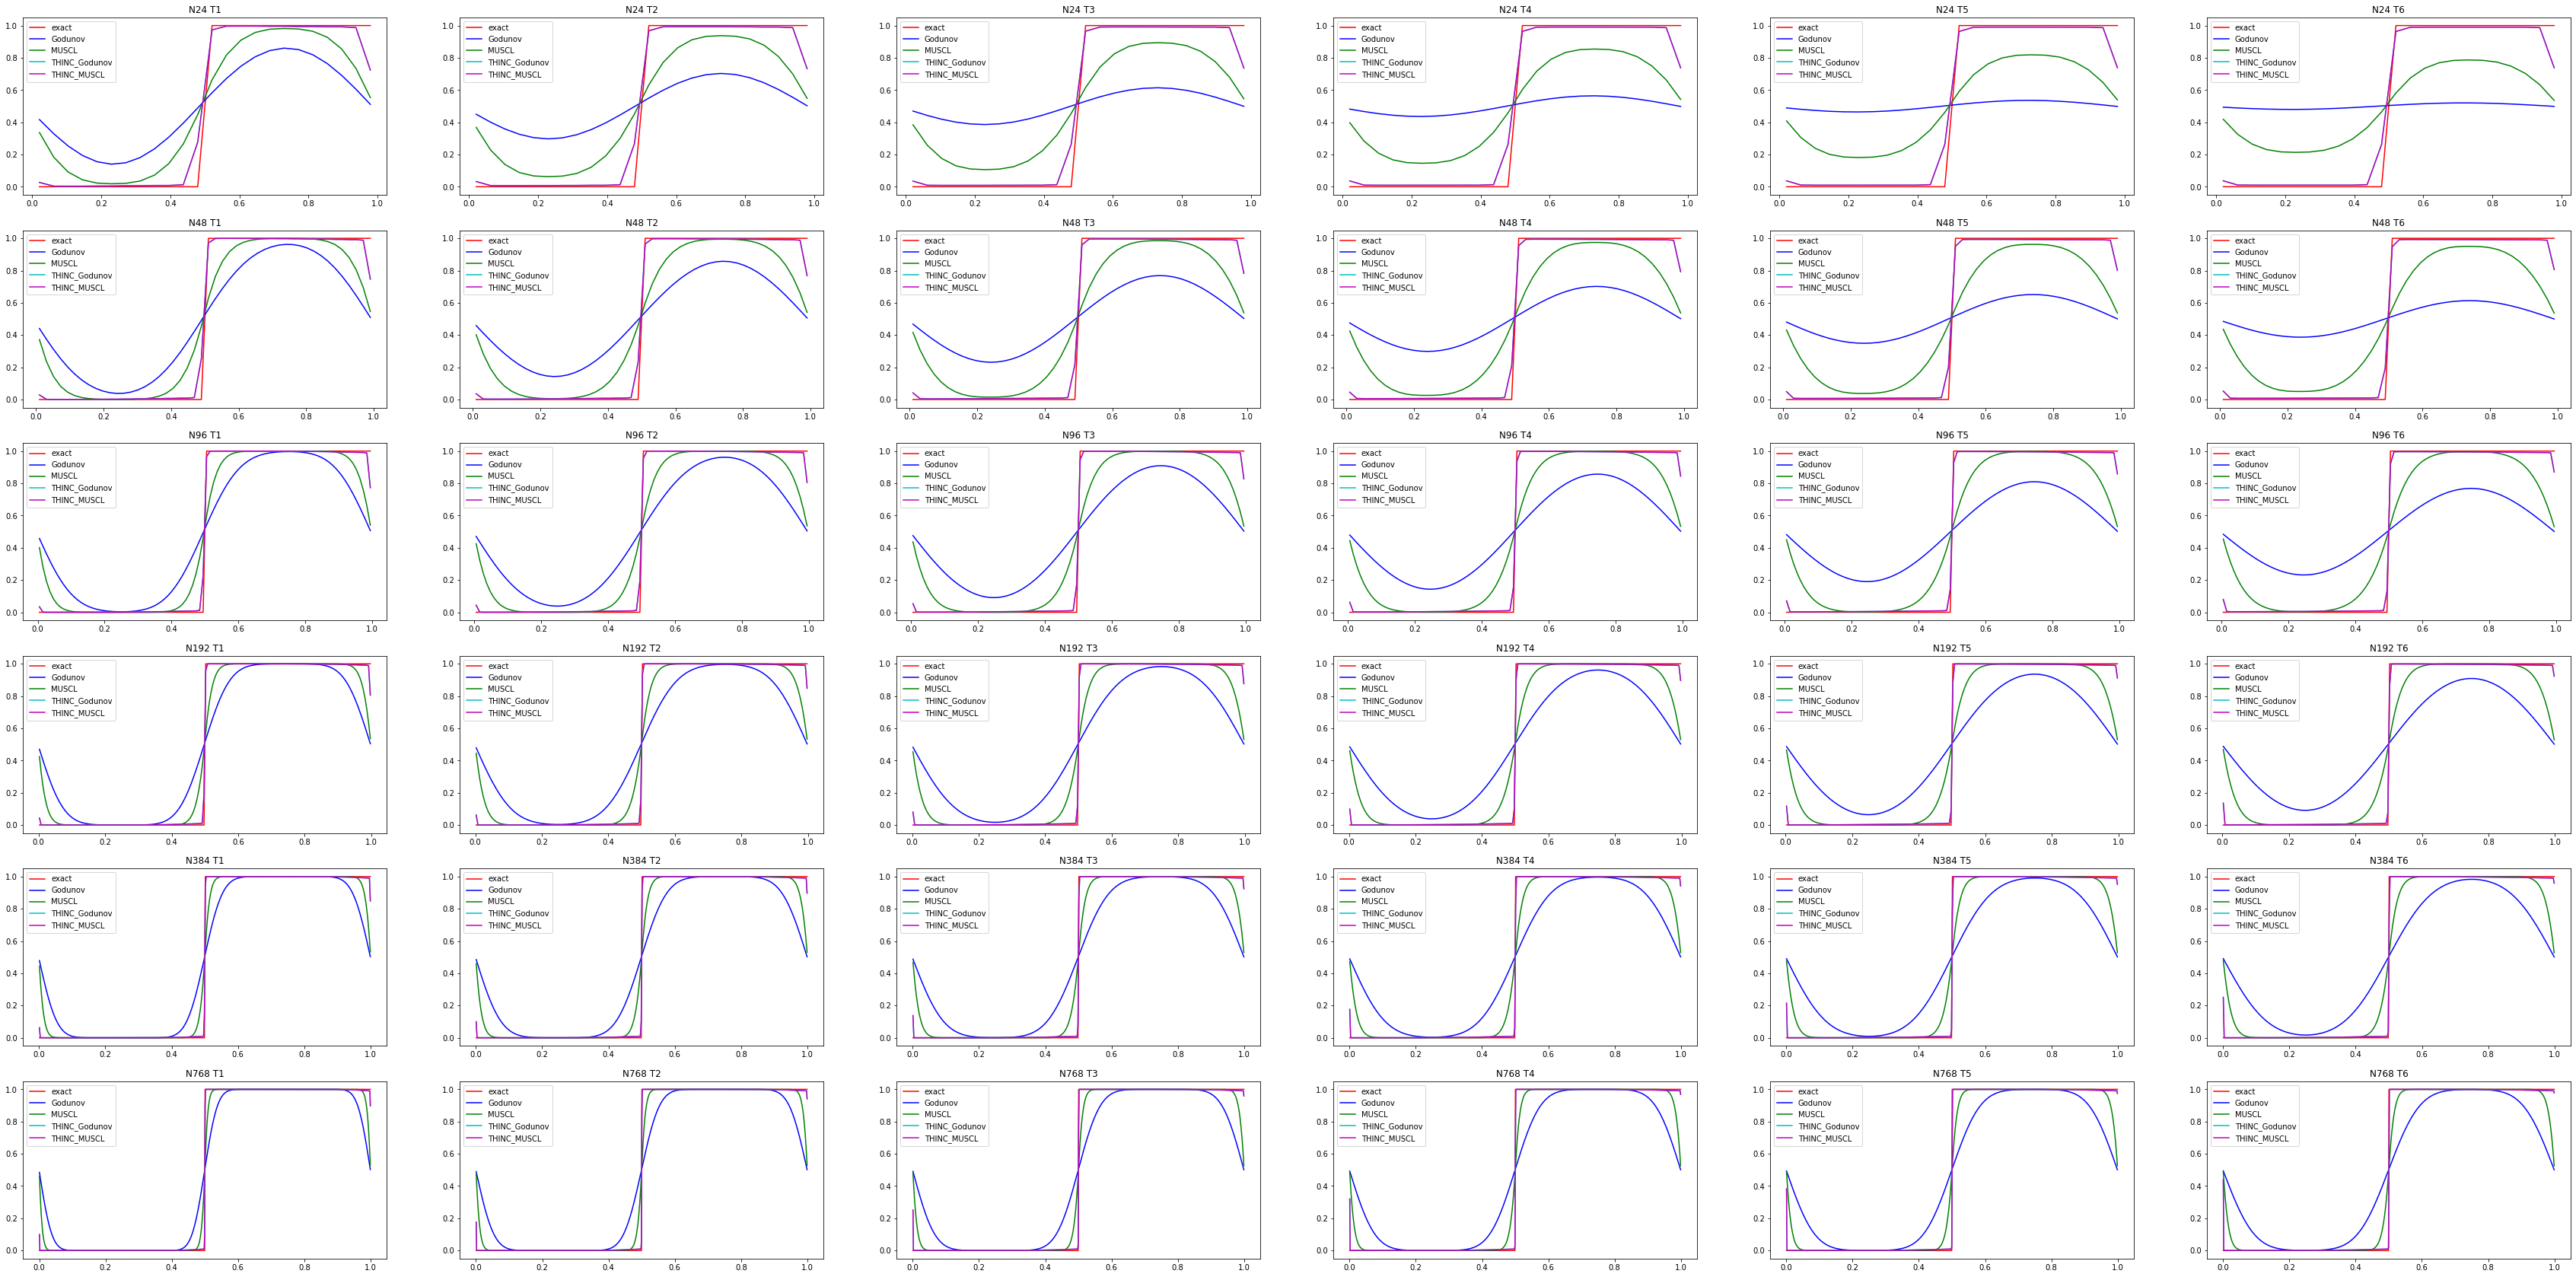

In [6]:
fig, axs = plt.subplots(6, 6, figsize=(60,30))

lineStyles = ["b-", "g-", "c-", "m-", "r-"]

for iN, N in enumerate(meshesN):
    for iT in range(0, 6):
        T = iT+1
        x = [row[0] for row in solutions["exact"][N]]
        y = [row[1] for row in solutions["exact"][N]]
        axs[iN, iT].plot(x, y, lineStyles[-1], label='exact')
        
        for i, method in enumerate(subcats):
            x = [row[0] for row in solutions[subcats[i]][N][T]]
            y = [row[1] for row in solutions[subcats[i]][N][T]]
            axs[iN, iT].plot(x, y, lineStyles[i], label=subcats[i])
        axs[iN, iT].set_title("N"+str(N)+" T"+str(T))
        axs[iN, iT].legend()

plt.savefig("solutions.png")
#for ax in axs.flat:
    #ax.set(xlabel='x-label', ylabel='y-label')


Сравнение решений на различных сетках для всех периодов и методов 

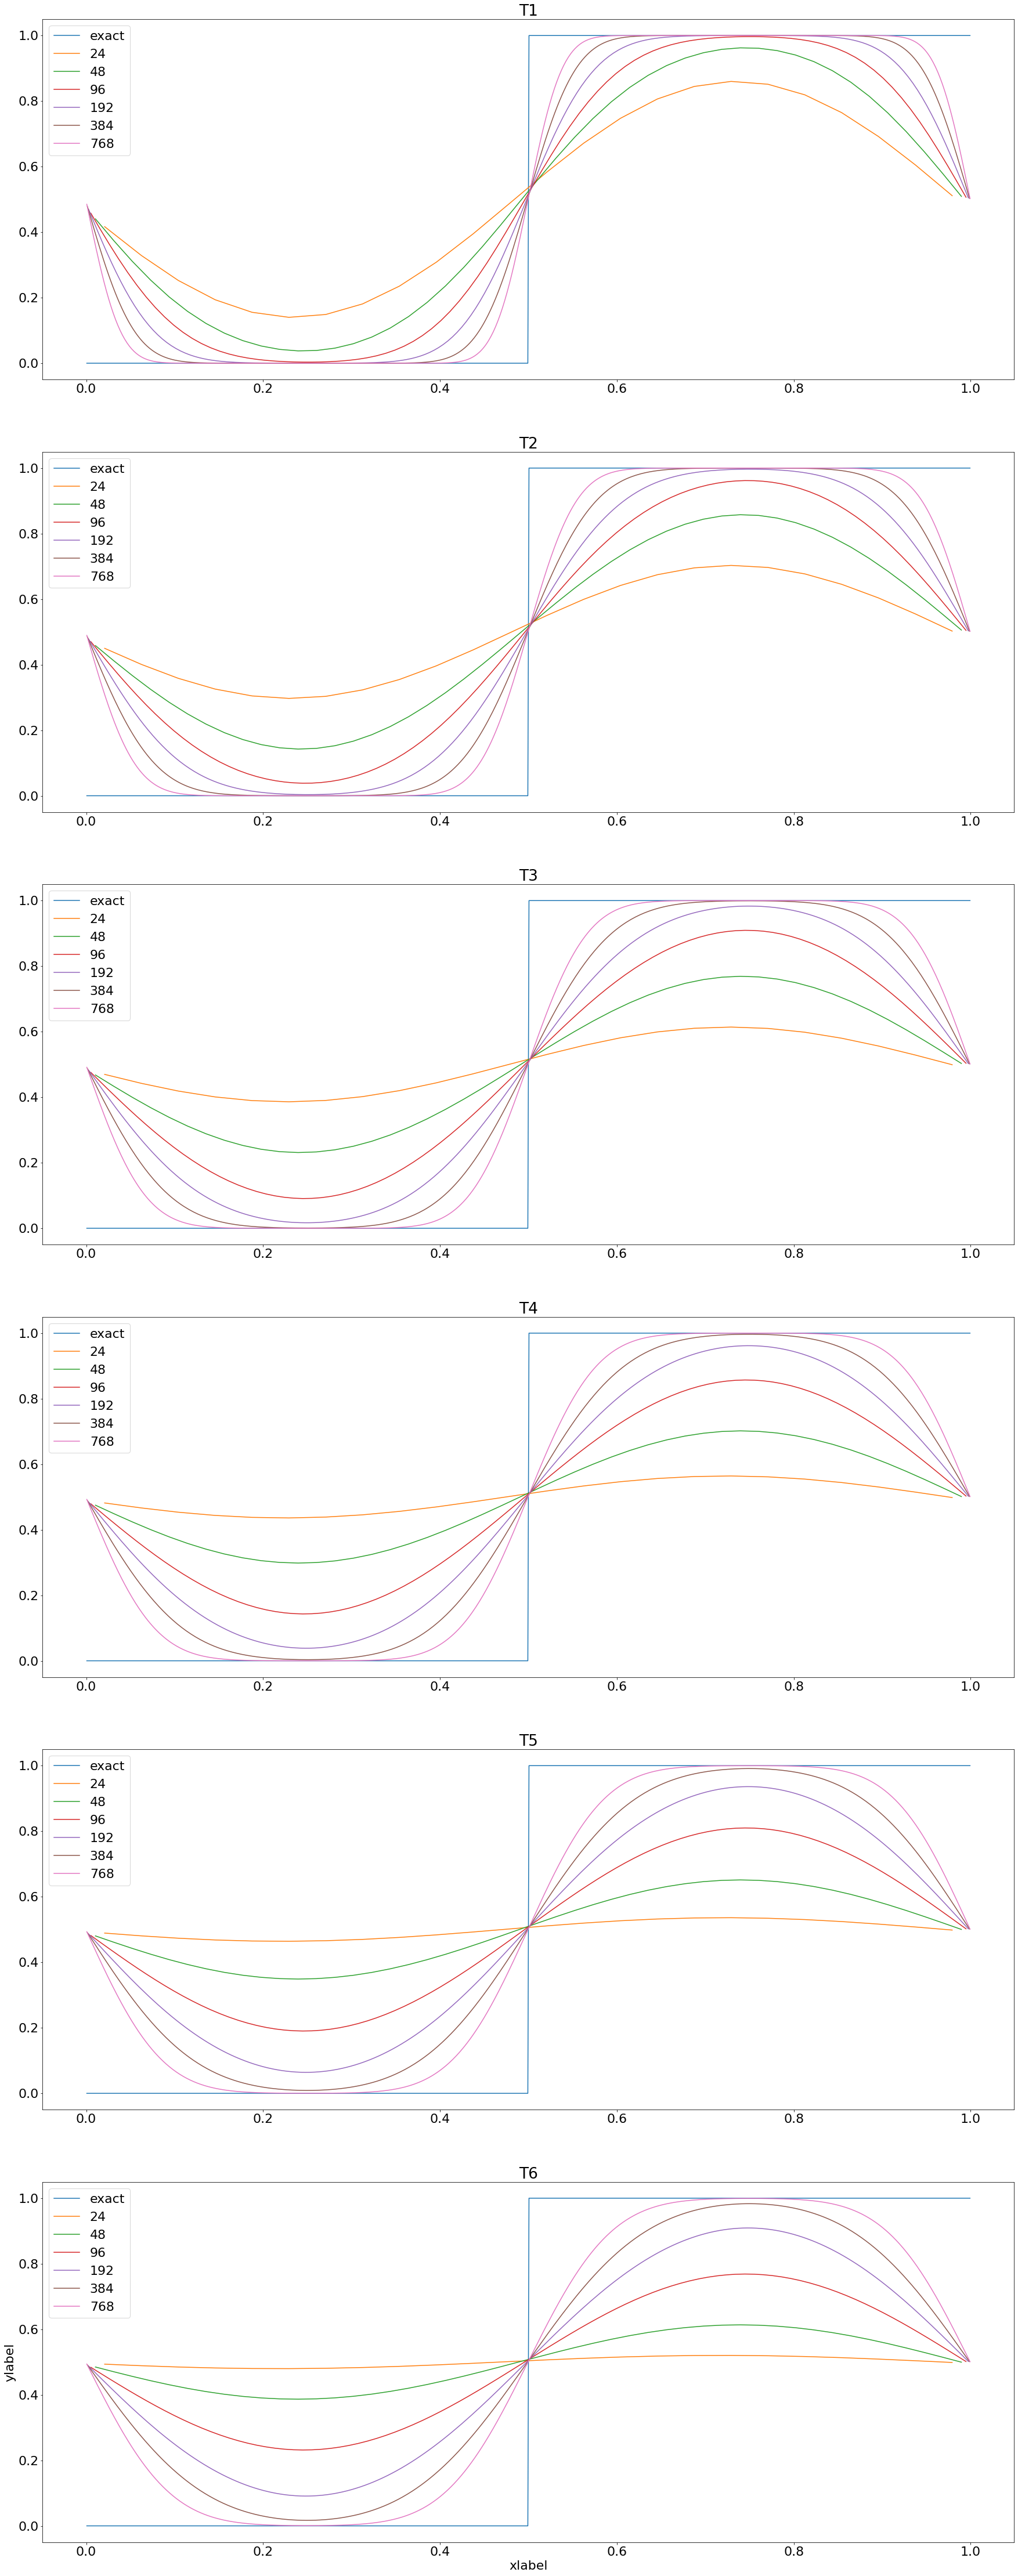

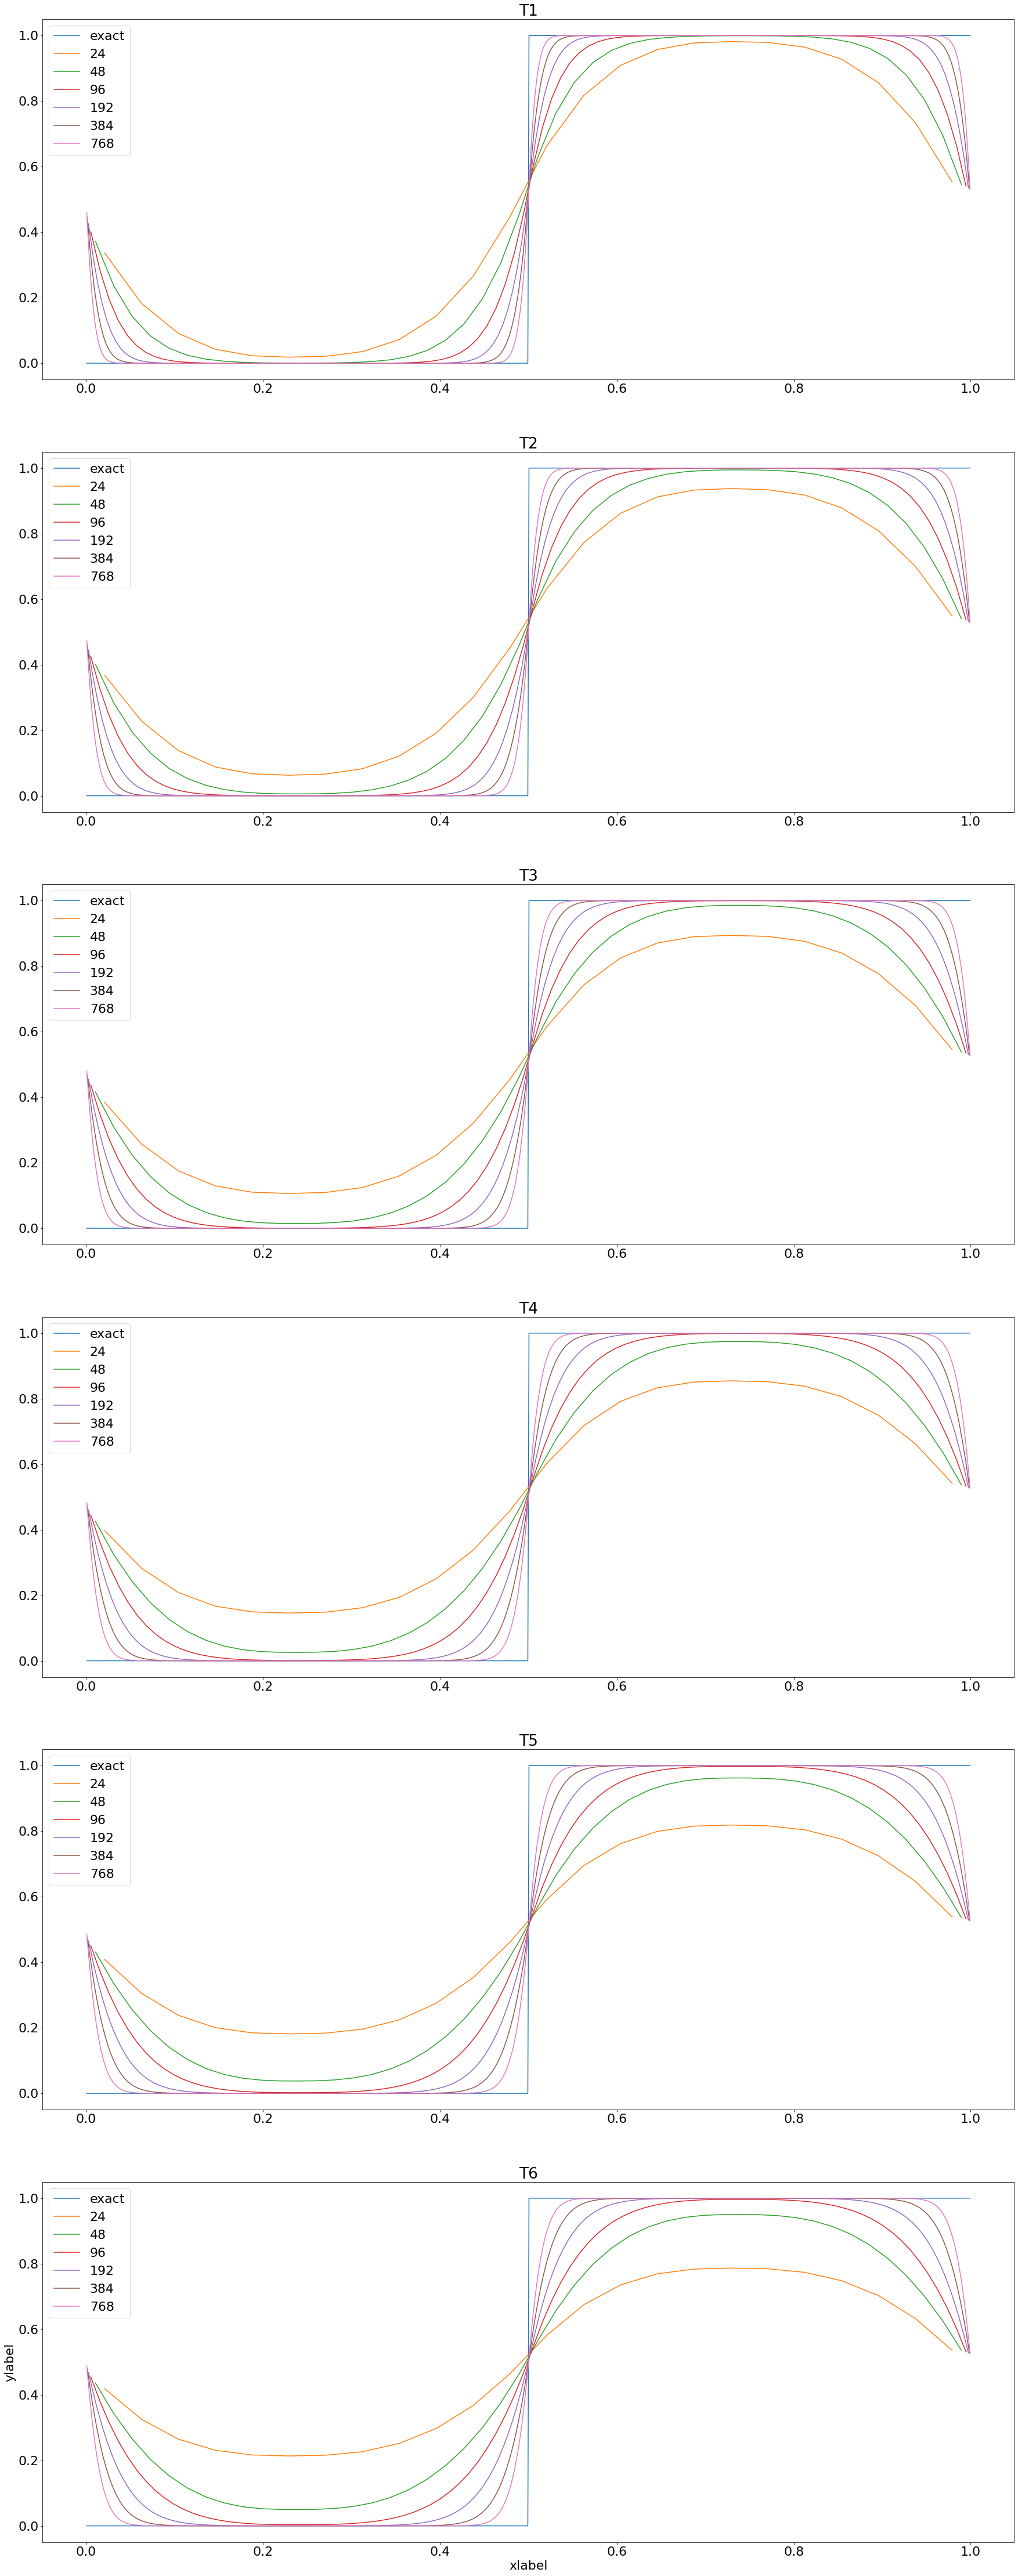

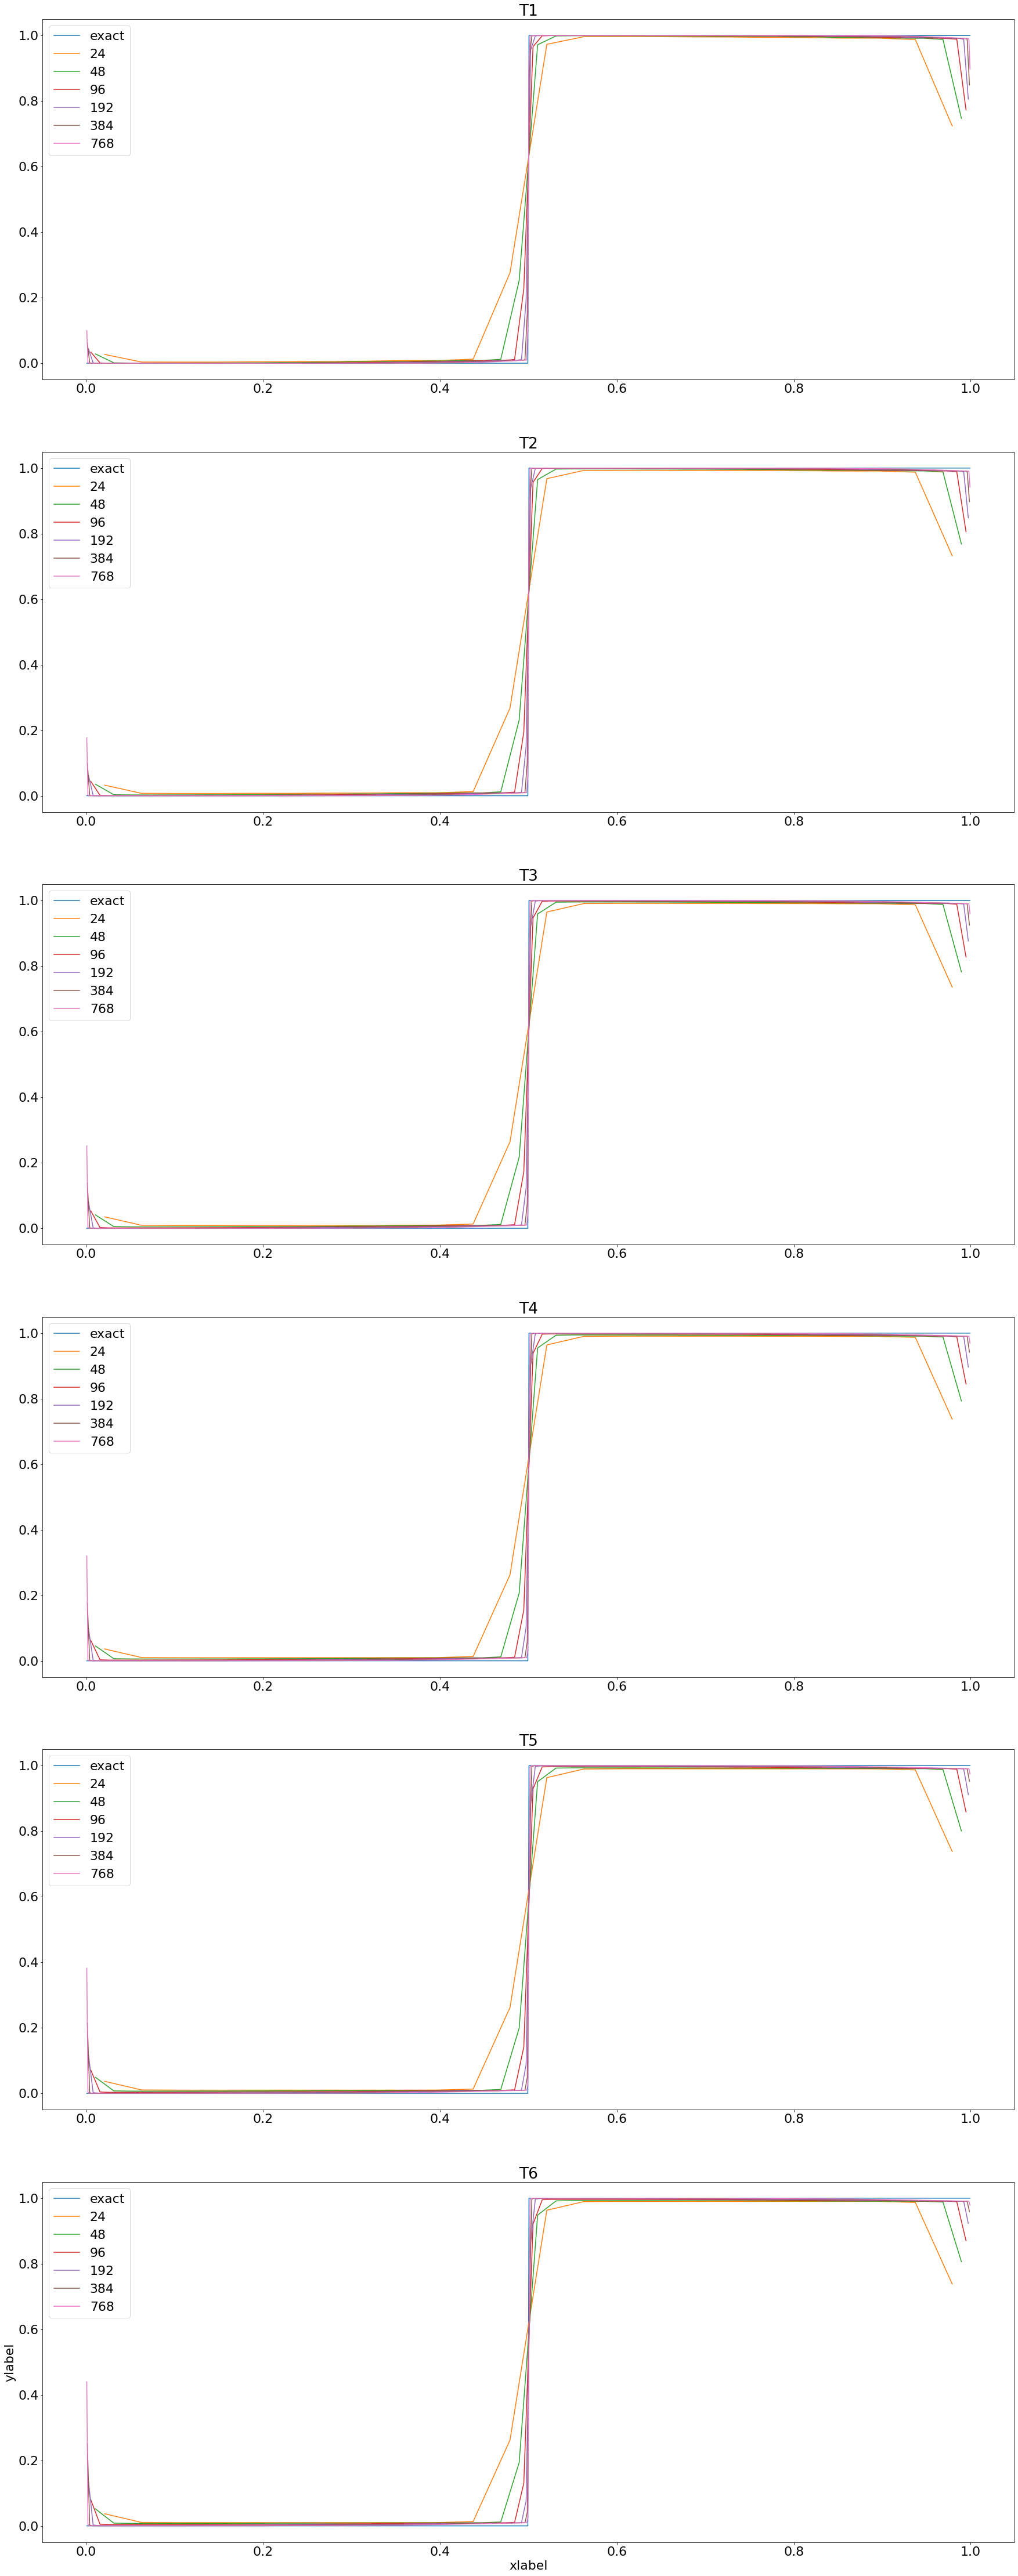

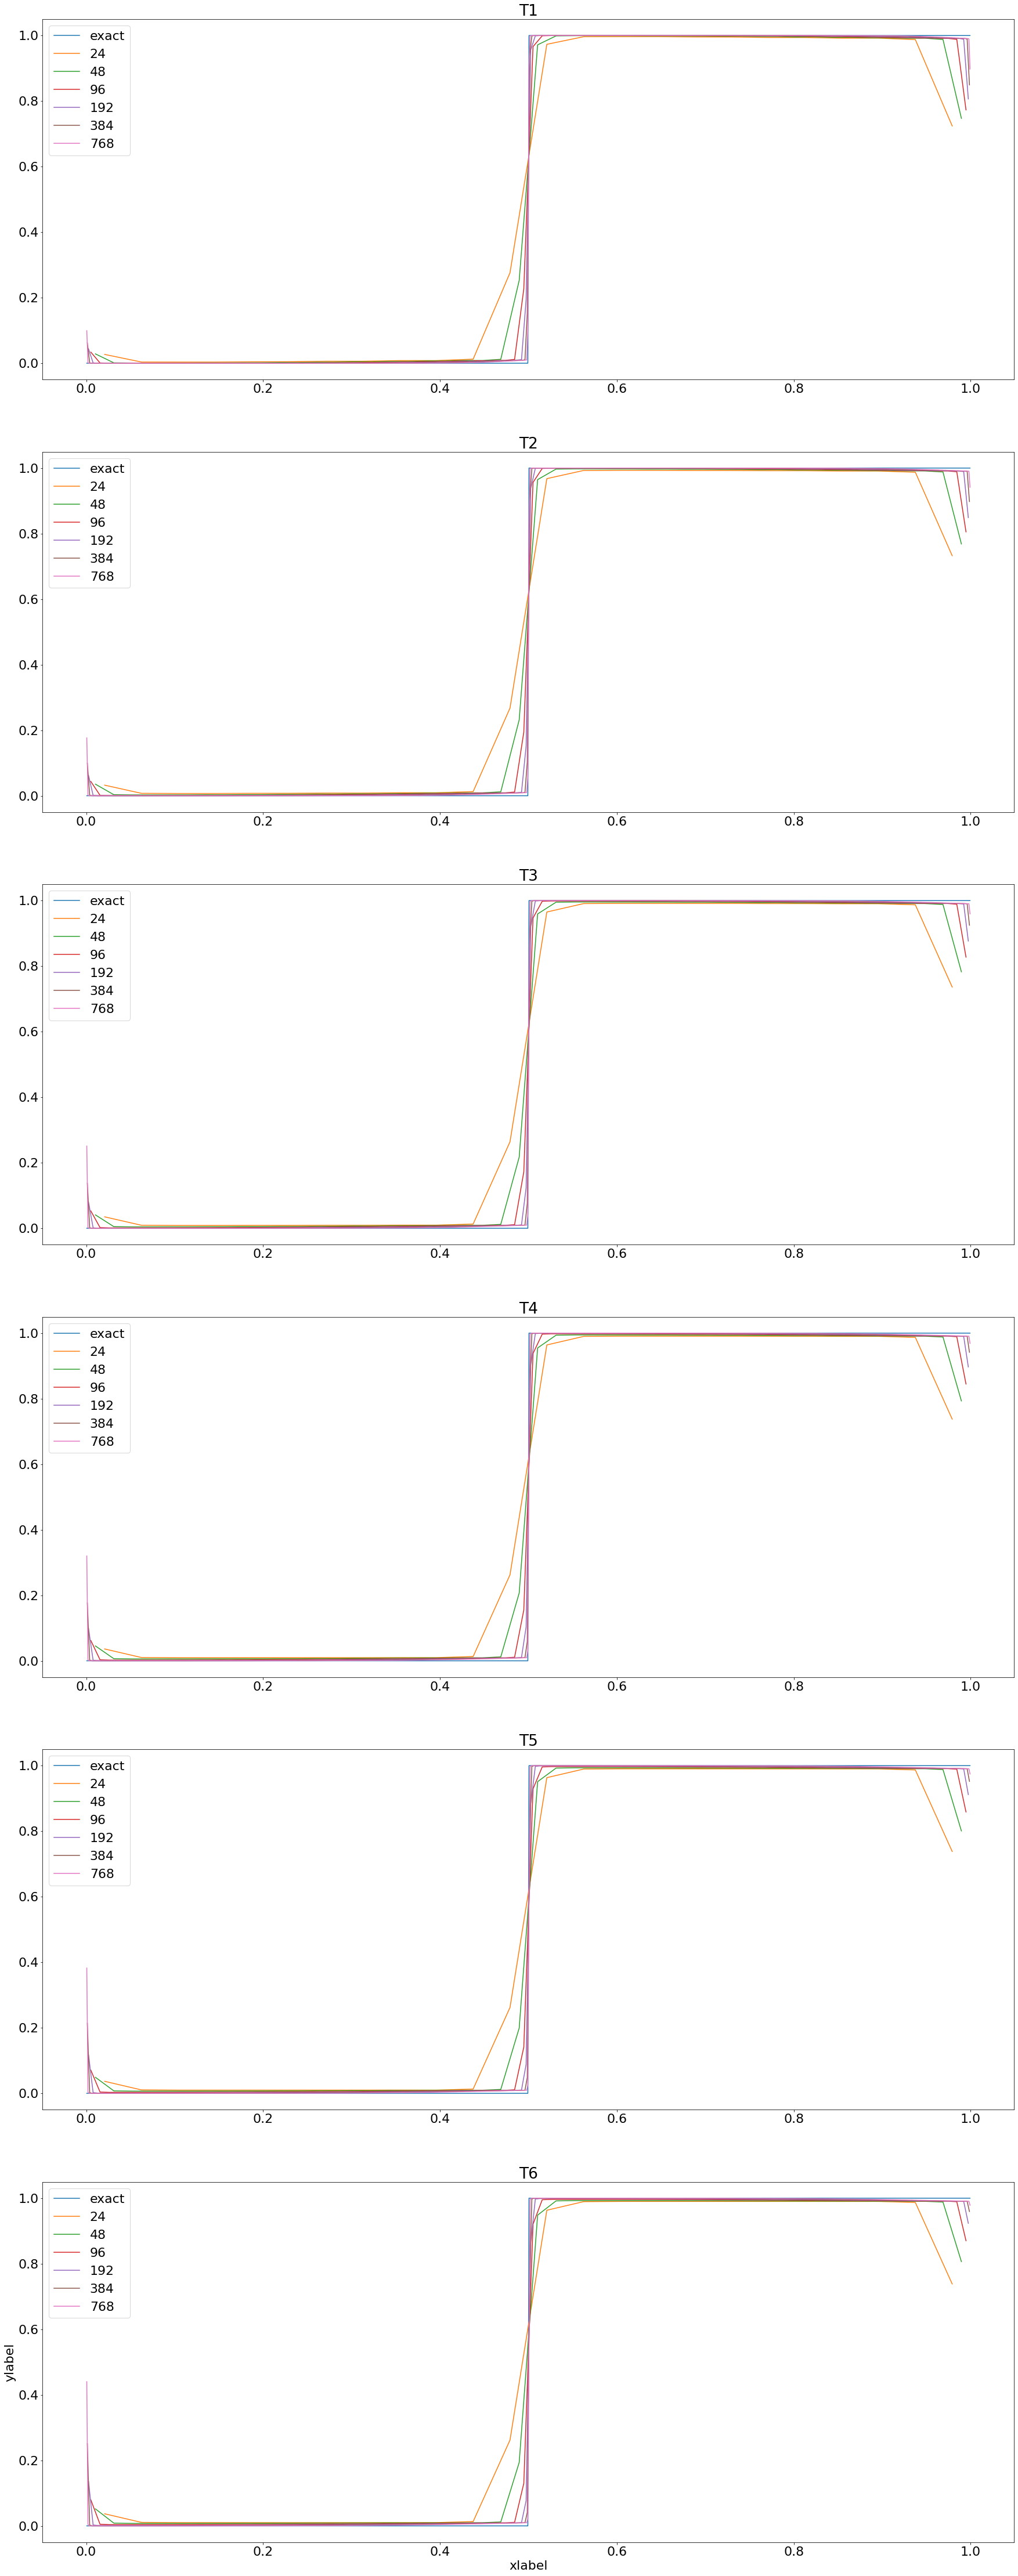

In [8]:
for method in subcats:
    fig, axs = plt.subplots(6, 1, figsize=(30,80))
    plt.rcParams.update({'font.size': 22})
    plt.xlabel('xlabel', fontsize=22)
    plt.ylabel('ylabel', fontsize=22)
    for iT in range(0, 6):
        T = iT+1
    
        x = [row[0] for row in solutions["exact"][meshesN[-1]]]
        y = [row[1] for row in solutions["exact"][meshesN[-1]]]
        axs[iT].plot(x, y, label='exact')
    
        for iN, N in enumerate(meshesN):
            x = [row[0] for row in solutions[method][N][T]]
            y = [row[1] for row in solutions[method][N][T]]
            axs[iT].plot(x, y, label=str(N))
        axs[iT].set_title("T"+str(T))
        axs[iT].legend()
    
    plt.savefig(method+".png")

### Графики ошибки и исследование сходимости

Метод обладает сходимостью степени b если существует 0 < a <= 1 :
существует натуральное N и для любого n>=N:
error(n, T) < a * error(n-1, T) ^ b

Скорость сходимости была оценена как тангенс угла наклона графика зависимости log(error(n, T)) от log(error(n-1, T)).
так как
log(error(n, T)) < log(a) + k * log(error(n-1, T))

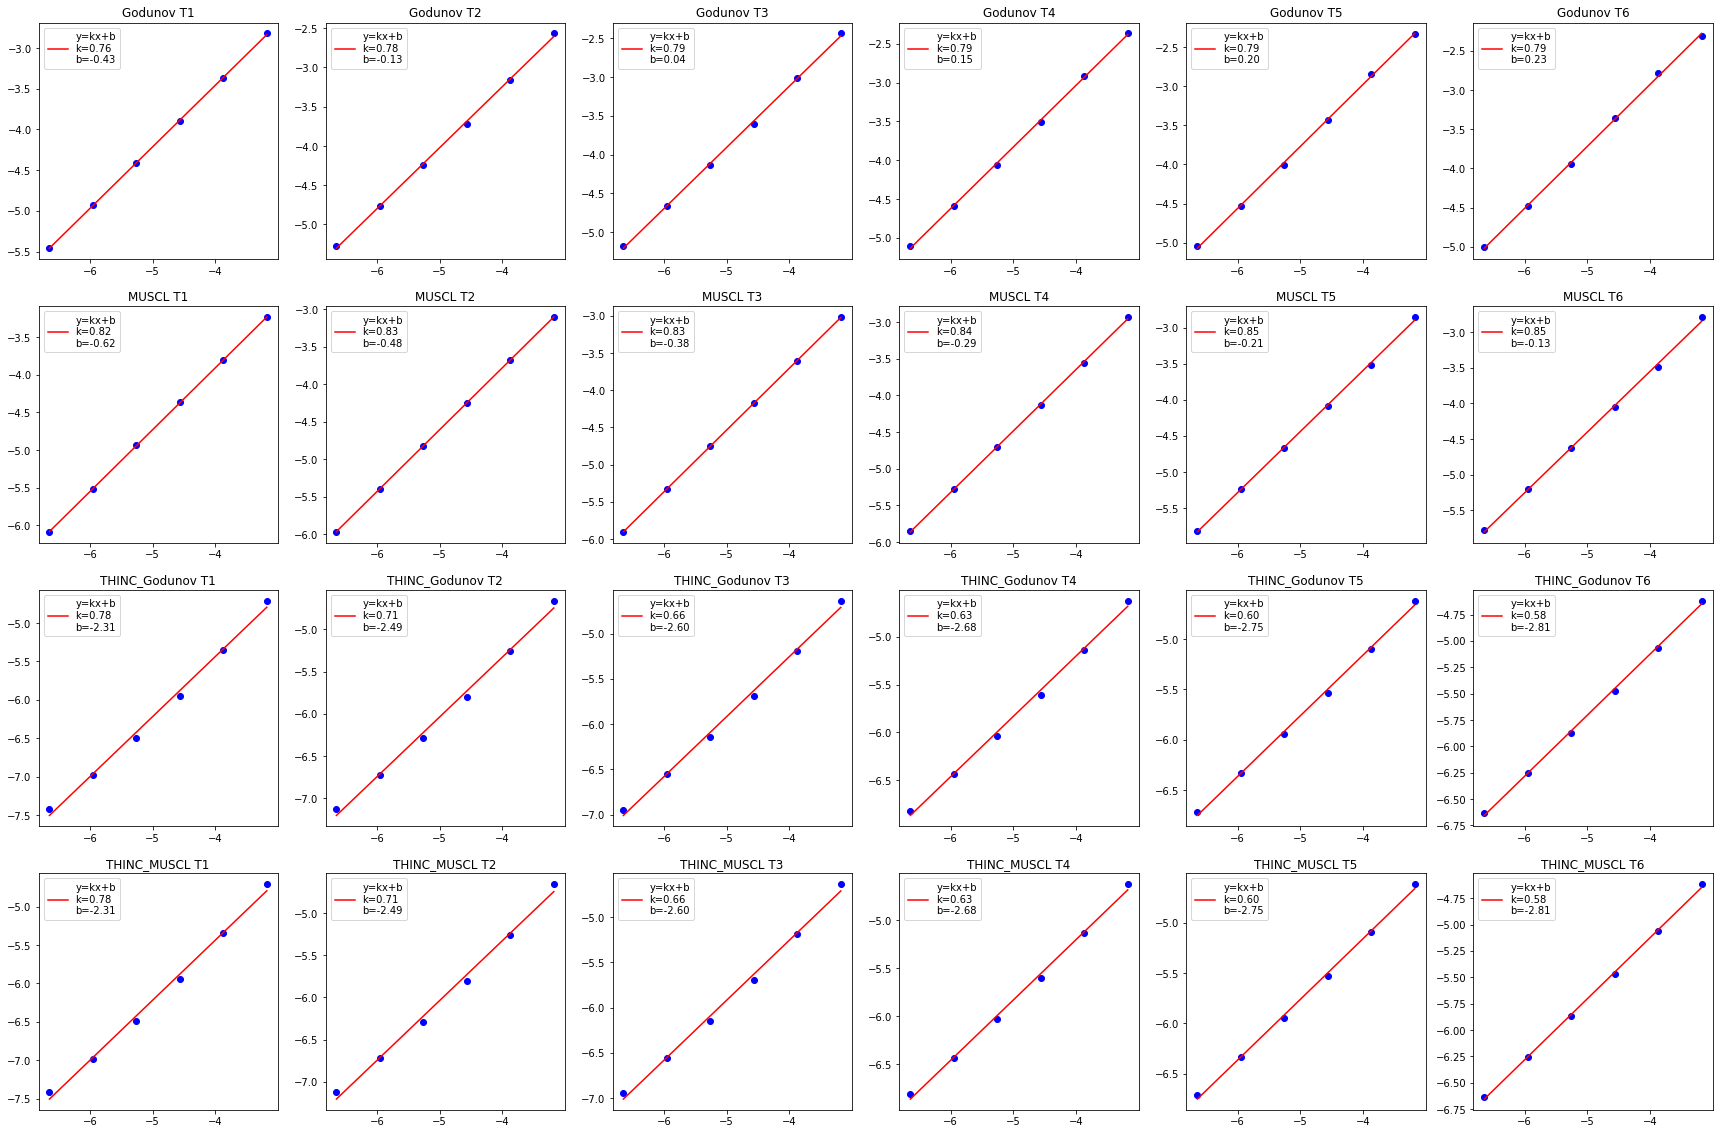

In [8]:
import numpy as np
import math

fig, axs = plt.subplots(4, 6, figsize=(30,20))
for m, method in enumerate(subcats):
    for i, T in enumerate(periodsT):
        x = []
        y = []
        for N in meshesN:
            x.append(math.log(1.0/N))
            #x.append(math.log(errors[method][meshesN[j-1]][T]))
            y.append(math.log(errors[method][N][T]))
        kb = np.polyfit(x,y,1)
        xApprox = [min(x), max(x)]
        yApprox = [kb[0]*xApprox[0]+kb[1], kb[0]*xApprox[1]+kb[1]]
        
        axs[m, i].plot(x, y, 'bo')
        axs[m, i].plot(xApprox, yApprox, 'r-', label='y=kx+b\nk='+"{:.2f}".format(kb[0])+"\nb="+"{:.2f}".format(kb[1]))
        axs[m, i].legend()
        axs[m, i].set_title(method+" T"+str(T))
plt.savefig("ErrorConvergence.png")

### Построение анимации

#### Начальные условия

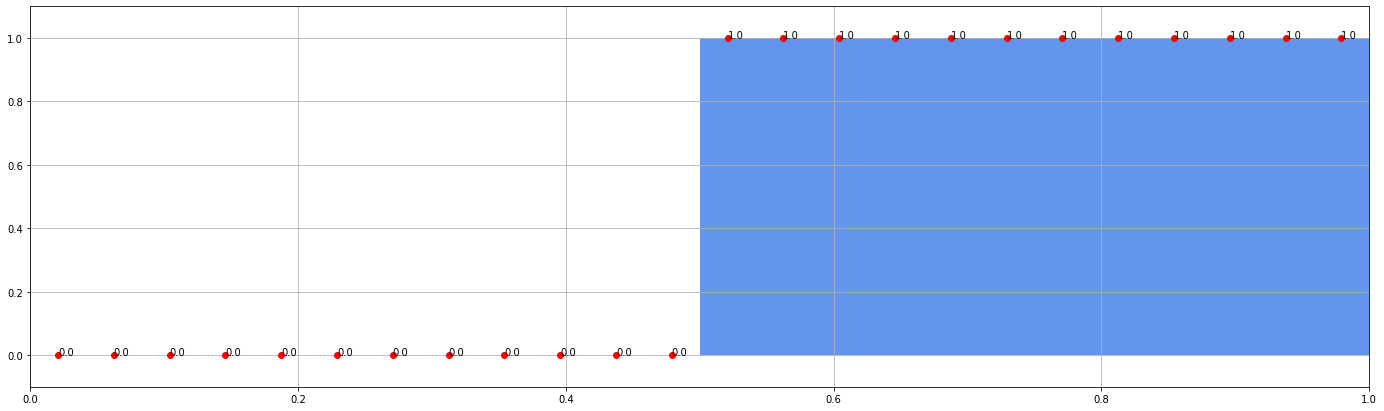

In [6]:
frames = read1DArea(cat+"/"+subcats[1]+"/N24_T1.txt")
#frames = read1DArea("THINC1DOutput.txt")

h = frames[0][1][0]-frames[0][0][0]
fig = plt.figure(figsize=(len(frames[0]), 7))
ax = plt.axes(xlim=(0, h*len(frames[0])), ylim=(-0.1, 1.1))
ax.grid()

x = [row[0] for row in frames[0]]
y = [row[1] for row in frames[0]]

plt.bar(x, y, color = ['cornflowerblue'], width = h)
plt.plot(x, y, 'ro')
for i,j in zip(x,y):
    ax.annotate(str(j),xy=(i,j))
plt.savefig("init.png")

#### Запись анимации движения

MovieWriter PillowWriter unavailable; using Pillow instead.


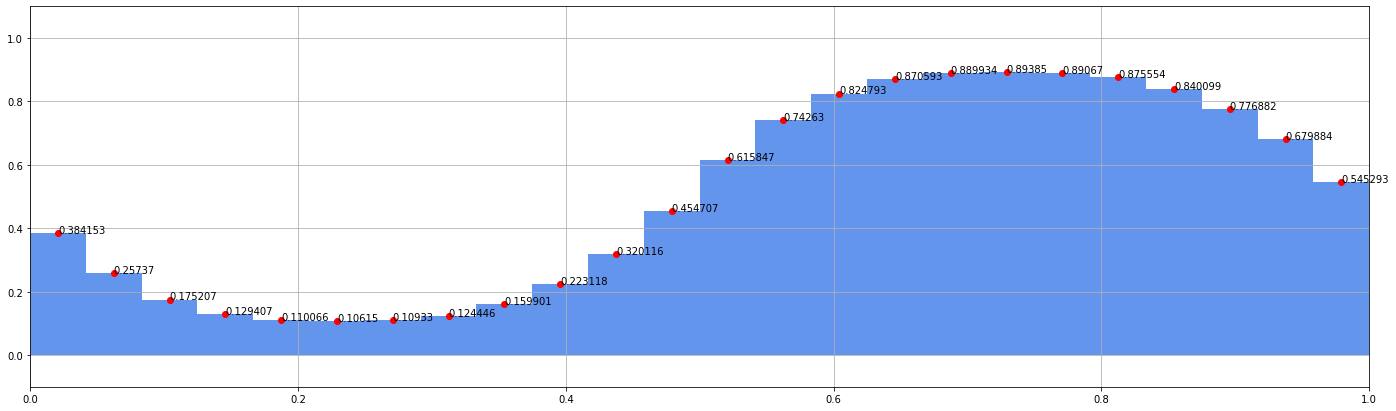

In [10]:
# Major ticks every 20, minor ticks every 5
#major_ticks = np.arange(-0.5, 20, 0.1)
#minor_ticks = np.arange(-0.5, 20, 0.01)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
#ax.grid(which='both')
fig = plt.figure(figsize=(len(frames[0]), 7))
ax = plt.axes(xlim=(0, h*len(frames[0])), ylim=(-0.1, 1.1))
ax.grid()

camera = Camera(fig)
for frame in frames:
    x = [row[0] for row in frame]
    y = [row[1] for row in frame]
    
    plt.bar(x, y, color = ['cornflowerblue'], width = h)
    plt.plot(x, y, 'ro')
    for i,j in zip(x,y):
        ax.annotate(str(j),xy=(i,j))
    
    camera.snap()

animation = camera.animate()
animation.save('animation.gif', writer='PillowWriter', fps=max(2, int(len(frames)/20)))